In [ ]:
import os
import urllib
import json
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fpdf import FPDF

In [60]:
def import_json_to_dict(url) :
    response = urllib.request.urlopen(url)
    my_dict = json.loads(response.read())
    return my_dict

In [61]:
def mkdir_ifnotexist(path) :
    if not os.path.isdir(path) :
        os.mkdir(path)

In [62]:
def format_amount(indic, valeur):
    if "Montant" in indic:
        f_valeur = float(valeur)
        if f_valeur > 1000000:
            return str(round(f_valeur/1000000, 1)) + ' M€'
        elif f_valeur > 10000:
            return str(round(f_valeur/1000, 1)) + ' k€'
        else:
            return str(f_valeur)
    else:
        return int(valeur.split(".")[0])

In [63]:
mailles = ["national", "regional", "departemental"]

In [88]:
pp_dep = pd.read_csv("pp_dep.csv", sep=";", dtype={"reg":str})

In [89]:
list_mesure_indic = list(pp_dep.pivot_table(index=["short_mesure", "short_indic"], values="valeur").index)

In [66]:
short_mesures_to_keep =set([
'AAP et AMI Efficacité énergétique',
'Assurance prospection',
"Ma Prime Rénov'",
"Prime à l'embauche des jeunes",
"Prime à l'embauche pour les travailleurs handicapés",
"Apprentissage",
"Bonus électrique",
"Contrats Initiatives Emploi (CIE) Jeunes",
'Contrats de professionnalisation',
'France Num : aide à la numérisation des TPE,PME,ETI',
'Garantie jeunes',
"AAP industrie : Modernisation des filières auto et aéro",
"Parcours emploi compétences (PEC) Jeunes",
'Prime à la conversion des véhicules légers',
"AAP Industrie : Soutien aux projets industriels territoires",
"AAP Industrie : Sécurisation approvisionnements critiques",
"Renforcement subventions Business France",
'Rénovation des bâtiments Etats (marchés notifiés)',
"Service civique",
'Soutien recherche aéronautique civil'
])
#print(list_mesure_indic)
#print(list(x[0] for x in list_mesure_indic if not(x[0] in short_mesures_to_keep)))
list_mesure_indic = [x for x in list_mesure_indic if x[0] in short_mesures_to_keep]

In [67]:
pp_reg = pd.pivot_table(pp_dep, index=["mesure","short_mesure", "reg","region", "Date", "period_date", "short_indic"], values="valeur", aggfunc=np.sum)
pp_reg.rename(columns={"reg":"libelle"}, inplace=True)
pp_reg.reset_index(inplace=True)

In [68]:
pp_nat = pd.pivot_table(pp_reg, index=["mesure", "short_mesure", "Date","period_date", "short_indic"], values="valeur", aggfunc=np.sum)
pp_nat.reset_index(inplace=True)

In [72]:
dict_mesure_indic = {}
for x in list_mesure_indic:
    if x[0] in dict_mesure_indic:
        dict_mesure_indic[x[0]].append(x[1])
    else:
        dict_mesure_indic[x[0]] = [x[1]]

In [90]:
dict_mesure_indic['AAP Industrie : Soutien aux projets industriels territoires'] = ['Nombre de TPE,PME,ETI bénéficiaires']
dict_mesure_indic['AAP Industrie : Sécurisation approvisionnements critiques'] = ['Nombre de TPE,PME,ETI bénéficiaires']
dict_mesure_indic['AAP et AMI Efficacité énergétique'] = ["Nombre d'entreprises ayant reçu l'aide"]
dict_mesure_indic['AAP industrie : Modernisation des filières auto et aéro'] = ['Nombre de PME']

In [91]:
# On ne veut pas afficher les lignes de Prime Rénov nulles
pp_dep = pp_dep.loc[(pp_dep.short_mesure != "Ma Prime Rénov'") | (pp_dep.valeur != 0) ]

In [92]:
pp_dep.valeur = pp_dep.valeur.astype(str)
pp_dep.valeur = pp_dep.apply(lambda x: format_amount(x["short_indic"], x["valeur"]), axis=1)

In [ ]:
pp_reg.valeur = pp_reg.valeur.astype(str)
pp_reg.valeur = pp_reg.apply(lambda x: format_amount(x["short_indic"], x["valeur"]), axis=1)

In [ ]:
pp_nat.valeur = pp_nat.valeur.astype(str)
pp_nat.valeur = pp_nat.apply(lambda x: format_amount(x["short_indic"], x["valeur"]), axis=1)

In [95]:
taxo_dep_url = 'https://raw.githubusercontent.com/etalab/dashboard-aides-entreprises/master/backend/json/taxonomies/departements-minify.json'
taxo_reg_url = 'https://raw.githubusercontent.com/etalab/dashboard-aides-entreprises/master/backend/json/taxonomies/regions-minify.json'

In [96]:
taxo_dep_df = pd.DataFrame(import_json_to_dict(taxo_dep_url))
dep_list = list(taxo_dep_df['dep'])
print('{} departements.'.format(len(dep_list)))

taxo_reg_df = pd.DataFrame(import_json_to_dict(taxo_reg_url))
reg_list = list(taxo_reg_df['reg'])
print('{} regions.'.format(len(reg_list)))

101 departements.
18 regions.


In [97]:
#Building the folders structures
pp_img_dir_path = './pp_img'
img_dir_path = './img/'
reports_dir_path = './reports/'

mkdir_ifnotexist(pp_img_dir_path)
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'national'))
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'national', 'France'))

#Regions subfolders
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'regional'))
for reg in reg_list :
    mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'regional', reg))
    
#Departements subfolders
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'departemental'))
for dep in dep_list :
    mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'departemental', dep))

mkdir_ifnotexist(reports_dir_path)

In [98]:
def make_pp_chart(maille, mesure, short_indic) :
    if maille == "departemental":
        df = pp_dep.loc[(pp_dep.short_mesure == mesure) 
                        & (pp_dep.short_indic == short_indic)
                       ].sort_values(by="period_date", ascending=True).copy()
        df.rename(columns={"valeur":short_indic}, inplace=True)
        deps = pp_dep.dep.unique()
        
        default = df.groupby(["Date", "period_date"]).sum().sort_values("period_date", ascending=True).reset_index()
        default[short_indic] = 0
        default = default[["Date", short_indic]]

        for dep in deps:
            print(f"Plotting {mesure}-{short_indic} : departement {dep}")
            df_plot = df.loc[(df.dep == dep)][["Date", short_indic]]
            if df_plot.shape[0] == 0:
                ax = pp_plot(default)
            else:
                ax = pp_plot(df_plot)
            save_pp_plot(maille, dep, mesure, short_indic, ax)
            
    elif maille == "regional":
        df = pp_reg.loc[(pp_reg.short_mesure == mesure) 
                & (pp_reg.short_indic == short_indic)
                ].sort_values(by="period_date", ascending=True).copy()
        df.rename(columns={"valeur":short_indic}, inplace=True)
        regs = df.reg.unique()
        
        default = df.groupby(["Date", "period_date"]).sum().sort_values("period_date", ascending=True).reset_index()
        default[short_indic] = 0
        default = default[["Date", short_indic]]

        for reg in regs:
            print(f"Plotting region {mesure}-{short_indic} : {reg}")
            df_plot = df.loc[(df.reg == reg)][["Date", short_indic]]
            if df_plot.shape[0] == 0:
                ax = pp_plot(default)
            else:
                ax = pp_plot(df_plot)
            save_pp_plot(maille, reg, mesure, short_indic, ax)
            
    elif maille == "national":
        print(f"Plotting country {mesure}-{short_indic}")
        df = pp_nat.loc[(pp_nat.short_mesure == mesure) 
                & (pp_nat.short_indic == short_indic)
                ].sort_values(by="period_date", ascending=True)[["Date", "valeur"]].copy()
        df.rename(columns={"valeur":short_indic}, inplace=True)
        ax = pp_plot(df)#, mesure, short_indic, "France")
        save_pp_plot(maille, "France", mesure, short_indic, ax)

In [99]:
def pp_plot(data, col_width=12, row_height=1.2, font_size=20,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])
    return ax

In [100]:
def save_pp_plot(maille, geo, mesure, short_indic, ax):
    #print(maille, geo, mesure, short_indic)
    path = os.path.join("pp_img", maille, geo)
    ax.figure.savefig(os.path.join(path, "{}-{}.png".format(mesure, short_indic)))
    plt.close()

In [101]:
def make_all_charts():
    for short_mesure in dict_mesure_indic:
        short_indic = dict_mesure_indic[short_mesure][0]
        for maille in mailles :
            make_pp_chart(maille, short_mesure, short_indic)

Plotting country AAP Industrie : Soutien aux projets industriels territoires-Nombre de TPE,PME,ETI bénéficiaires
Plotting region AAP Industrie : Soutien aux projets industriels territoires-Nombre de TPE,PME,ETI bénéficiaires : 28
Plotting region AAP Industrie : Soutien aux projets industriels territoires-Nombre de TPE,PME,ETI bénéficiaires : 93
Plotting region AAP Industrie : Soutien aux projets industriels territoires-Nombre de TPE,PME,ETI bénéficiaires : 84
Plotting region AAP Industrie : Soutien aux projets industriels territoires-Nombre de TPE,PME,ETI bénéficiaires : 76
Plotting region AAP Industrie : Soutien aux projets industriels territoires-Nombre de TPE,PME,ETI bénéficiaires : 75
Plotting region AAP Industrie : Soutien aux projets industriels territoires-Nombre de TPE,PME,ETI bénéficiaires : 53
Plotting region AAP Industrie : Soutien aux projets industriels territoires-Nombre de TPE,PME,ETI bénéficiaires : 52
Plotting region AAP Industrie : Soutien aux projets industriels terr

Plotting AAP Industrie : Soutien aux projets industriels territoires-Nombre de TPE,PME,ETI bénéficiaires : departement 02
Plotting AAP Industrie : Soutien aux projets industriels territoires-Nombre de TPE,PME,ETI bénéficiaires : departement 73
Plotting AAP Industrie : Soutien aux projets industriels territoires-Nombre de TPE,PME,ETI bénéficiaires : departement 58
Plotting AAP Industrie : Soutien aux projets industriels territoires-Nombre de TPE,PME,ETI bénéficiaires : departement 976
Plotting AAP Industrie : Soutien aux projets industriels territoires-Nombre de TPE,PME,ETI bénéficiaires : departement 78
Plotting AAP Industrie : Soutien aux projets industriels territoires-Nombre de TPE,PME,ETI bénéficiaires : departement 971
Plotting AAP Industrie : Soutien aux projets industriels territoires-Nombre de TPE,PME,ETI bénéficiaires : departement 05
Plotting AAP Industrie : Soutien aux projets industriels territoires-Nombre de TPE,PME,ETI bénéficiaires : departement 84
Plotting AAP Industrie

Plotting AAP Industrie : Sécurisation approvisionnements critiques-Nombre de TPE,PME,ETI bénéficiaires : departement 33
Plotting AAP Industrie : Sécurisation approvisionnements critiques-Nombre de TPE,PME,ETI bénéficiaires : departement 62
Plotting AAP Industrie : Sécurisation approvisionnements critiques-Nombre de TPE,PME,ETI bénéficiaires : departement 34
Plotting AAP Industrie : Sécurisation approvisionnements critiques-Nombre de TPE,PME,ETI bénéficiaires : departement 69
Plotting AAP Industrie : Sécurisation approvisionnements critiques-Nombre de TPE,PME,ETI bénéficiaires : departement 974
Plotting AAP Industrie : Sécurisation approvisionnements critiques-Nombre de TPE,PME,ETI bénéficiaires : departement 973
Plotting AAP Industrie : Sécurisation approvisionnements critiques-Nombre de TPE,PME,ETI bénéficiaires : departement 75
Plotting AAP Industrie : Sécurisation approvisionnements critiques-Nombre de TPE,PME,ETI bénéficiaires : departement 13
Plotting AAP Industrie : Sécurisation 

Plotting AAP Industrie : Sécurisation approvisionnements critiques-Nombre de TPE,PME,ETI bénéficiaires : departement 90
Plotting AAP Industrie : Sécurisation approvisionnements critiques-Nombre de TPE,PME,ETI bénéficiaires : departement 71
Plotting AAP Industrie : Sécurisation approvisionnements critiques-Nombre de TPE,PME,ETI bénéficiaires : departement 79
Plotting AAP Industrie : Sécurisation approvisionnements critiques-Nombre de TPE,PME,ETI bénéficiaires : departement 66
Plotting AAP Industrie : Sécurisation approvisionnements critiques-Nombre de TPE,PME,ETI bénéficiaires : departement 81
Plotting AAP Industrie : Sécurisation approvisionnements critiques-Nombre de TPE,PME,ETI bénéficiaires : departement 54
Plotting AAP Industrie : Sécurisation approvisionnements critiques-Nombre de TPE,PME,ETI bénéficiaires : departement 29
Plotting AAP Industrie : Sécurisation approvisionnements critiques-Nombre de TPE,PME,ETI bénéficiaires : departement 63
Plotting AAP Industrie : Sécurisation ap

Plotting AAP et AMI Efficacité énergétique-Nombre d'entreprises ayant reçu l'aide : departement 32
Plotting AAP et AMI Efficacité énergétique-Nombre d'entreprises ayant reçu l'aide : departement 46
Plotting AAP et AMI Efficacité énergétique-Nombre d'entreprises ayant reçu l'aide : departement 74
Plotting AAP et AMI Efficacité énergétique-Nombre d'entreprises ayant reçu l'aide : departement 68
Plotting AAP et AMI Efficacité énergétique-Nombre d'entreprises ayant reçu l'aide : departement 39
Plotting AAP et AMI Efficacité énergétique-Nombre d'entreprises ayant reçu l'aide : departement 48
Plotting AAP et AMI Efficacité énergétique-Nombre d'entreprises ayant reçu l'aide : departement 87
Plotting AAP et AMI Efficacité énergétique-Nombre d'entreprises ayant reçu l'aide : departement 76
Plotting AAP et AMI Efficacité énergétique-Nombre d'entreprises ayant reçu l'aide : departement 65
Plotting AAP et AMI Efficacité énergétique-Nombre d'entreprises ayant reçu l'aide : departement 23
Plotting A

Plotting AAP industrie : Modernisation des filières auto et aéro-Nombre de PME : departement 34
Plotting AAP industrie : Modernisation des filières auto et aéro-Nombre de PME : departement 69
Plotting AAP industrie : Modernisation des filières auto et aéro-Nombre de PME : departement 974
Plotting AAP industrie : Modernisation des filières auto et aéro-Nombre de PME : departement 973
Plotting AAP industrie : Modernisation des filières auto et aéro-Nombre de PME : departement 75
Plotting AAP industrie : Modernisation des filières auto et aéro-Nombre de PME : departement 13
Plotting AAP industrie : Modernisation des filières auto et aéro-Nombre de PME : departement 72
Plotting AAP industrie : Modernisation des filières auto et aéro-Nombre de PME : departement 61
Plotting AAP industrie : Modernisation des filières auto et aéro-Nombre de PME : departement 16
Plotting AAP industrie : Modernisation des filières auto et aéro-Nombre de PME : departement 77
Plotting AAP industrie : Modernisation

Plotting AAP industrie : Modernisation des filières auto et aéro-Nombre de PME : departement 57
Plotting AAP industrie : Modernisation des filières auto et aéro-Nombre de PME : departement 972
Plotting AAP industrie : Modernisation des filières auto et aéro-Nombre de PME : departement 12
Plotting AAP industrie : Modernisation des filières auto et aéro-Nombre de PME : departement 49
Plotting AAP industrie : Modernisation des filières auto et aéro-Nombre de PME : departement 67
Plotting AAP industrie : Modernisation des filières auto et aéro-Nombre de PME : departement 01
Plotting AAP industrie : Modernisation des filières auto et aéro-Nombre de PME : departement 11
Plotting AAP industrie : Modernisation des filières auto et aéro-Nombre de PME : departement 38
Plotting country Apprentissage-Nombre de contrats d’apprentissage
Plotting region Apprentissage-Nombre de contrats d’apprentissage : 01
Plotting region Apprentissage-Nombre de contrats d’apprentissage : 84
Plotting region Apprentis

Plotting Apprentissage-Nombre de contrats d’apprentissage : departement 09
Plotting Apprentissage-Nombre de contrats d’apprentissage : departement 60
Plotting Apprentissage-Nombre de contrats d’apprentissage : departement 25
Plotting Apprentissage-Nombre de contrats d’apprentissage : departement 45
Plotting Apprentissage-Nombre de contrats d’apprentissage : departement 24
Plotting Apprentissage-Nombre de contrats d’apprentissage : departement 03
Plotting Apprentissage-Nombre de contrats d’apprentissage : departement 26
Plotting Apprentissage-Nombre de contrats d’apprentissage : departement 64
Plotting Apprentissage-Nombre de contrats d’apprentissage : departement 70
Plotting Apprentissage-Nombre de contrats d’apprentissage : departement 88
Plotting Apprentissage-Nombre de contrats d’apprentissage : departement 57
Plotting Apprentissage-Nombre de contrats d’apprentissage : departement 972
Plotting Apprentissage-Nombre de contrats d’apprentissage : departement 12
Plotting Apprentissage-N

Plotting Assurance prospection-Nombre de TPE,PME,ETI bénéficiaires : departement 91
Plotting Assurance prospection-Nombre de TPE,PME,ETI bénéficiaires : departement 86
Plotting Assurance prospection-Nombre de TPE,PME,ETI bénéficiaires : departement 94
Plotting Assurance prospection-Nombre de TPE,PME,ETI bénéficiaires : departement 83
Plotting Assurance prospection-Nombre de TPE,PME,ETI bénéficiaires : departement 2A
Plotting Assurance prospection-Nombre de TPE,PME,ETI bénéficiaires : departement 53
Plotting Assurance prospection-Nombre de TPE,PME,ETI bénéficiaires : departement 92
Plotting Assurance prospection-Nombre de TPE,PME,ETI bénéficiaires : departement 15
Plotting Assurance prospection-Nombre de TPE,PME,ETI bénéficiaires : departement 90
Plotting Assurance prospection-Nombre de TPE,PME,ETI bénéficiaires : departement 71
Plotting Assurance prospection-Nombre de TPE,PME,ETI bénéficiaires : departement 79
Plotting Assurance prospection-Nombre de TPE,PME,ETI bénéficiaires : departe

Plotting Bonus électrique-Nombre de bonus octroyés à des véhicules électriques : departement 65
Plotting Bonus électrique-Nombre de bonus octroyés à des véhicules électriques : departement 23
Plotting Bonus électrique-Nombre de bonus octroyés à des véhicules électriques : departement 55
Plotting Bonus électrique-Nombre de bonus octroyés à des véhicules électriques : departement 10
Plotting Bonus électrique-Nombre de bonus octroyés à des véhicules électriques : departement 22
Plotting Bonus électrique-Nombre de bonus octroyés à des véhicules électriques : departement 31
Plotting Bonus électrique-Nombre de bonus octroyés à des véhicules électriques : departement 93
Plotting Bonus électrique-Nombre de bonus octroyés à des véhicules électriques : departement 42
Plotting Bonus électrique-Nombre de bonus octroyés à des véhicules électriques : departement 41
Plotting Bonus électrique-Nombre de bonus octroyés à des véhicules électriques : departement 36
Plotting Bonus électrique-Nombre de bonu

Plotting Contrats Initiatives Emploi (CIE) Jeunes-Entrées de jeunes en CIE : departement 28
Plotting Contrats Initiatives Emploi (CIE) Jeunes-Entrées de jeunes en CIE : departement 43
Plotting Contrats Initiatives Emploi (CIE) Jeunes-Entrées de jeunes en CIE : departement 18
Plotting Contrats Initiatives Emploi (CIE) Jeunes-Entrées de jeunes en CIE : departement 50
Plotting Contrats Initiatives Emploi (CIE) Jeunes-Entrées de jeunes en CIE : departement 04
Plotting Contrats Initiatives Emploi (CIE) Jeunes-Entrées de jeunes en CIE : departement 21
Plotting Contrats Initiatives Emploi (CIE) Jeunes-Entrées de jeunes en CIE : departement 07
Plotting Contrats Initiatives Emploi (CIE) Jeunes-Entrées de jeunes en CIE : departement 19
Plotting Contrats Initiatives Emploi (CIE) Jeunes-Entrées de jeunes en CIE : departement 85
Plotting Contrats Initiatives Emploi (CIE) Jeunes-Entrées de jeunes en CIE : departement 56
Plotting Contrats Initiatives Emploi (CIE) Jeunes-Entrées de jeunes en CIE : dep

Plotting region Contrats de professionnalisation-Nombre de contrats de professionnalisation : 52
Plotting region Contrats de professionnalisation-Nombre de contrats de professionnalisation : 44
Plotting region Contrats de professionnalisation-Nombre de contrats de professionnalisation : 32
Plotting region Contrats de professionnalisation-Nombre de contrats de professionnalisation : 28
Plotting region Contrats de professionnalisation-Nombre de contrats de professionnalisation : 27
Plotting region Contrats de professionnalisation-Nombre de contrats de professionnalisation : 24
Plotting region Contrats de professionnalisation-Nombre de contrats de professionnalisation : 11
Plotting region Contrats de professionnalisation-Nombre de contrats de professionnalisation : 06
Plotting region Contrats de professionnalisation-Nombre de contrats de professionnalisation : 04
Plotting region Contrats de professionnalisation-Nombre de contrats de professionnalisation : 03
Plotting region Contrats de pr

Plotting Contrats de professionnalisation-Nombre de contrats de professionnalisation : departement 71
Plotting Contrats de professionnalisation-Nombre de contrats de professionnalisation : departement 79
Plotting Contrats de professionnalisation-Nombre de contrats de professionnalisation : departement 66
Plotting Contrats de professionnalisation-Nombre de contrats de professionnalisation : departement 81
Plotting Contrats de professionnalisation-Nombre de contrats de professionnalisation : departement 54
Plotting Contrats de professionnalisation-Nombre de contrats de professionnalisation : departement 29
Plotting Contrats de professionnalisation-Nombre de contrats de professionnalisation : departement 63
Plotting Contrats de professionnalisation-Nombre de contrats de professionnalisation : departement 89
Plotting Contrats de professionnalisation-Nombre de contrats de professionnalisation : departement 2B
Plotting Contrats de professionnalisation-Nombre de contrats de professionnalisati

Plotting France Num : aide à la numérisation des TPE,PME,ETI-Nombre d'accompagnements dispensés : departement 80
Plotting France Num : aide à la numérisation des TPE,PME,ETI-Nombre d'accompagnements dispensés : departement 51
Plotting France Num : aide à la numérisation des TPE,PME,ETI-Nombre d'accompagnements dispensés : departement 32
Plotting France Num : aide à la numérisation des TPE,PME,ETI-Nombre d'accompagnements dispensés : departement 46
Plotting France Num : aide à la numérisation des TPE,PME,ETI-Nombre d'accompagnements dispensés : departement 74
Plotting France Num : aide à la numérisation des TPE,PME,ETI-Nombre d'accompagnements dispensés : departement 68
Plotting France Num : aide à la numérisation des TPE,PME,ETI-Nombre d'accompagnements dispensés : departement 39
Plotting France Num : aide à la numérisation des TPE,PME,ETI-Nombre d'accompagnements dispensés : departement 48
Plotting France Num : aide à la numérisation des TPE,PME,ETI-Nombre d'accompagnements dispensés 

Plotting region Garantie jeunes-Entrées en garanties jeunes : 53
Plotting region Garantie jeunes-Entrées en garanties jeunes : 11
Plotting region Garantie jeunes-Entrées en garanties jeunes : 76
Plotting region Garantie jeunes-Entrées en garanties jeunes : 06
Plotting region Garantie jeunes-Entrées en garanties jeunes : 84
Plotting region Garantie jeunes-Entrées en garanties jeunes : 04
Plotting region Garantie jeunes-Entrées en garanties jeunes : 03
Plotting region Garantie jeunes-Entrées en garanties jeunes : 93
Plotting region Garantie jeunes-Entrées en garanties jeunes : 02
Plotting region Garantie jeunes-Entrées en garanties jeunes : 52
Plotting Garantie jeunes-Entrées en garanties jeunes : departement 14
Plotting Garantie jeunes-Entrées en garanties jeunes : departement 44
Plotting Garantie jeunes-Entrées en garanties jeunes : departement 33
Plotting Garantie jeunes-Entrées en garanties jeunes : departement 62
Plotting Garantie jeunes-Entrées en garanties jeunes : departement 34


Plotting region Ma Prime Rénov'-Montant total des primes versées : 27
Plotting region Ma Prime Rénov'-Montant total des primes versées : 24
Plotting region Ma Prime Rénov'-Montant total des primes versées : 11
Plotting region Ma Prime Rénov'-Montant total des primes versées : 94
Plotting region Ma Prime Rénov'-Montant total des primes versées : 01
Plotting region Ma Prime Rénov'-Montant total des primes versées : 04
Plotting region Ma Prime Rénov'-Montant total des primes versées : 02
Plotting region Ma Prime Rénov'-Montant total des primes versées : 03
Plotting Ma Prime Rénov'-Montant total des primes versées : departement 14
Plotting Ma Prime Rénov'-Montant total des primes versées : departement 44
Plotting Ma Prime Rénov'-Montant total des primes versées : departement 33
Plotting Ma Prime Rénov'-Montant total des primes versées : departement 62
Plotting Ma Prime Rénov'-Montant total des primes versées : departement 34
Plotting Ma Prime Rénov'-Montant total des primes versées : depar

KeyboardInterrupt: 

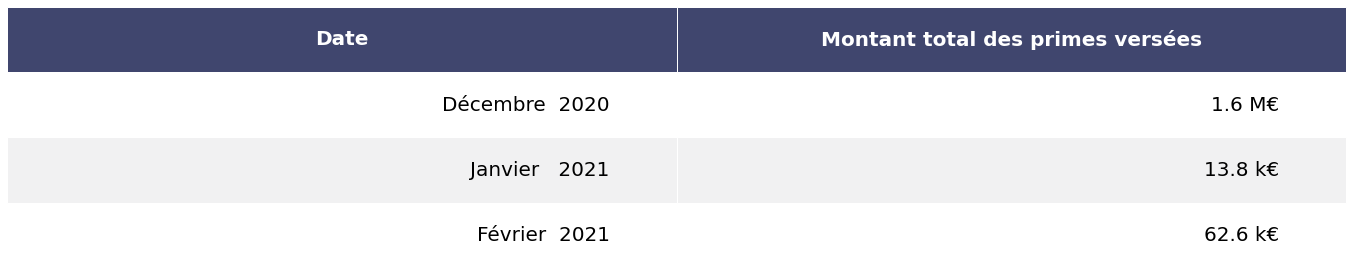

In [103]:
#%%time
make_all_charts()

In [ ]:
col_width=6.0
row_height=0.625
font_size=14

In [ ]:
global title_header
title_header = ''
global subtitle_header
subtitle_header = ''

In [ ]:
class PDF(FPDF):
    def header(self):
        if (self.page_no() != 1 ):
            # Logo
            self.image(os.path.join(img_dir_path, 'LogoRF.png'), 10, 8, 33)
            self.image(os.path.join(img_dir_path, 'logo_Francerelance_1321294.54.png'), pdf.w-45, 7, 45)
            # Arial bold 15
            self.cell(40)
            self.add_font('Arial', 'B', 16, uni=True)
            self.set_font('Arial', 'B', 16)
            self.multi_cell(110, 10, title_header, 0, 1, 'A')

            # Move to the right
            # Title
            self.set_font('Arial', 'I', 9)
            self.cell(50)
            self.cell(50)
            #self.cell(50, 10, subtitle_header, 0, 1, 'A')#+' - aides-entreprises.data.gouv.fr', 0, 1, 'A', link='https://aides-entreprises.data.gouv.fr/')
            # Line break  
            pdf.line(40, 38, 170, 38)
            self.ln(7)
        
    # Page footer
    def footer(self):
        if (self.page_no() != 1 ):
            # Position at 1.5 cm from bottom
            self.set_y(-15)
            # Arial italic 8
            self.set_font('Arial', 'I', 8)
            # Page number
            
            #self.cell(0, 10, 'Direction Interministérielle du Numérique (DINUM) - Page ' + str(self.page_no()) + '/{nb}', 0, 0, 'C')         

In [ ]:
def add_propilot_page_report(pdf, dep, short_mesure, phrase_nombre, source_dict):
    
    pdf.set_fill_color(83,101,125);

    pdf.set_y(47.00125)
    
    
    # Print KPI
    short_indic = dict_mesure_indic[short_mesure][0]
    kpi_dep = (pp_dep.loc[(pp_dep.dep == dep) 
                          & (pp_dep.short_mesure == short_mesure) 
                          & (pp_dep.short_indic == short_indic)]
                .sort_values(by="period_date", ascending=False))
    if kpi_dep.shape[0] != 0:
        date= kpi_dep.iloc[0].Date
        valeur = kpi_dep.iloc[0].valeur
    else:
        date = pp_dep.Date.max()
        valeur = 0
    
    pdf.add_font('Arial', '', 'arial.ttf', uni=True)
    pdf.set_font('Arial', '', 12)
    pdf.cell(12, 10, f"À {date}, {short_indic} : {valeur} (données cumulées)")
    pdf.ln(10)
 
    pdf.set_text_color(0,0,0)

    # Niveau National
    pdf.set_font('Arial', 'BI', 14)
    pdf.cell(65, 10, "Niveau National", ln=1)
    
    pdf.set_font('Arial', '', 14)

    hbar_w = 120
    pdf.image(os.path.join(pp_img_dir_path, 'national','France', f"{short_mesure}-{short_indic}.png"), 
              x=0, y=74, w=hbar_w)

    pdf.ln(12)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(10)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(27)

    reg = taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['reg']
    libelle_reg = taxo_reg_df[taxo_reg_df['reg'] == reg].iloc[0]['libelle']
    libelle_dep = taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['libelle']
    
    
    # Niveau Régional
    pdf.set_font('Arial', 'BI', 14)
    pdf.cell(65, 10, "Niveau Régional : "+libelle_reg, ln=1)

    pdf.set_font('Arial', '', 14)

    path_reg = os.path.join(pp_img_dir_path, 'regional',reg, f"{short_mesure}-{short_indic}.png")
    if os.path.exists(path_reg):    
        pdf.image(path_reg, x=0, y=133, w=hbar_w)
    pdf.ln(10)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(15)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(10)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(25)

    # Niveau Départemental
    pdf.set_font('Arial', 'BI', 14)
    pdf.cell(65, 15, "Niveau Départemental : "+libelle_dep, ln=1) 

    pdf.set_font('Arial', '', 14)
    path_dep = os.path.join(pp_img_dir_path, 'departemental', dep, f"{short_mesure}-{short_indic}.png")
    if os.path.exists(path_dep):
        pdf.image(path_dep, x=0, y=210, w=hbar_w)
        
    pdf.ln(8)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(15)
    pdf.cell((pdf.w/3)*1.55)
    
    return pdf

In [ ]:
#%%time

mkdir_ifnotexist(os.path.join(reports_dir_path))

counter = 0
for dep in taxo_dep_df.dep.unique():
    counter += 1
    
    pdf = PDF()
    pdf.alias_nb_pages()
    pdf.add_page()

    #Logos
    pdf.image(os.path.join(img_dir_path, 'LogoRF.png'), 10, 8, 33)
    pdf.image(os.path.join(img_dir_path, 'logo_Francerelance_1321294.54.png'), pdf.w-45, 7, 45)
    
    # Arial bold 15
    pdf.set_font('Arial', 'B', 28)
    # Move to the right
    pdf.cell(50)
    pdf.ln(70)
    
    # Title
    pdf.cell(10)
    pdf.cell(50, 10, 'SUIVI TERRITORIAL', 0, 1, 'A')
    pdf.ln(10)
    pdf.cell(10)
    pdf.cell(50, 10, 'DU PLAN DE RELANCE', 0, 1, 'A')
    pdf.ln(10)
    pdf.cell(10)
    pdf.cell(50)

    pdf.set_font('Arial', 'I', 20)
    pdf.ln(10)
    pdf.cell(10)
    pdf.cell(50, 10, 'Données pour le département : '+taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['libelle'], 0, 1, 'A')
    pdf.ln(110)

    pdf.set_font('Arial', 'I', 8)

    pdf.cell(10)
       
    # TEST PROPILOT
    for short_mesure in short_mesures_to_keep:
        source_dict= {'name':'Les données utilisées proviennent de ProPilot', 
                      'url':'https://dares.travail-emploi.gouv.fr/dares-etudes-et-statistiques/tableaux-de-bord/le-marche-du-travail-pendant-le-covid-19/tableaux-de-bord-hebdomadaires'}

        title_header = short_mesure
        
        pdf.add_page()
        pdf = add_propilot_page_report(pdf, dep, short_mesure,' : ', source_dict) 
    departement = taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['libelle']
    pdf.output(os.path.join(reports_dir_path, 'Suivi_territorial_plan_relance_'+ departement+'.pdf'), 'F')
    
    print(str(datetime.datetime.today()) + ' - ' + dep + ' done.')